In [1]:
from numba import jit, njit
import kwant
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
import kwant.kpm


import scipy

import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace

import cmath

from qutip import *
from joblib import Parallel, delayed

from scipy.ndimage import gaussian_filter

import pandas as pd

/opt/anaconda3/lib/python3.12/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [2]:
s_ = sigmam()

Delta = 0
Om = .222
gam = .044
deph = .044

Nd = 600
arr_Delta = np.linspace(-3,3,Nd)
arr_pop = np.zeros(Nd)
arr_pop2 = np.zeros(Nd)

for nD, Delta in enumerate(arr_Delta):
    H = Delta * s_.dag()*s_ + Om * ( s_ + s_.dag() )
    c_jumps = [gam**.5*s_, deph**.5*s_.dag()*s_]
    rhoss = steadystate(H, c_jumps)
    arr_pop[nD] = expect(s_.dag()*s_, rhoss)
    
    c_jumps = [gam**.5*s_, (10*deph)**.5*s_.dag()*s_]
    rhoss2 = steadystate(H, c_jumps)
    arr_pop2[nD] = expect(s_.dag()*s_, rhoss2)
    

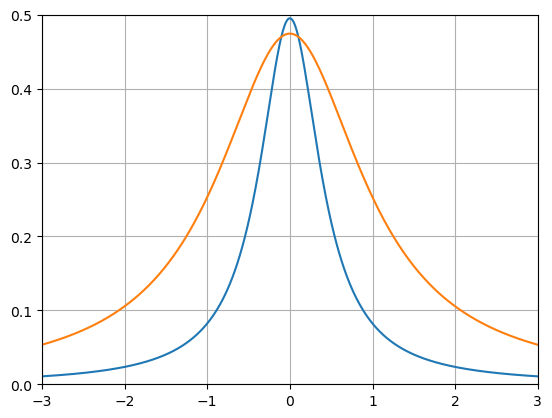

In [3]:
plt.plot(arr_Delta, arr_pop)
plt.plot(arr_Delta, arr_pop2)

plt.ylim(0,.5)
plt.xlim(-3,3)
plt.grid()

In [4]:
Nd = 1000
#arr_deph = np.linspace(0.001,30,Nd)
arr_deph = np.logspace(-4,2,Nd)
arr_pop_deph = np.zeros(Nd)
arr_pop_deph_OM = np.zeros(Nd)
arr_pop_gam = np.zeros(Nd)
Delta = .1
Om = .0222
gam = .044

for nD, deph in enumerate(arr_deph):
    H = Delta * s_.dag()*s_ + Om * ( s_ + s_.dag() )
    c_jumps = [gam**.5*s_, deph**.5*s_.dag()*s_]
    rhoss = steadystate(H, c_jumps)
    arr_pop_deph[nD] = expect(s_.dag()*s_, rhoss)
    
    H = Delta * s_.dag()*s_ + Om * ( s_ + s_.dag() )
    c_jumps = [ (gam+deph)**.5*s_ ]
    rhoss = steadystate(H, c_jumps)
    arr_pop_gam[nD] = expect(s_.dag()*s_, rhoss)
    
    H = Delta * s_.dag()*s_ + Om * (1. - (deph/np.amax(arr_deph)) )**4. * ( s_ + s_.dag() )
    c_jumps = [gam**.5*s_, deph**.5*s_.dag()*s_]
    rhoss = steadystate(H, c_jumps)
    arr_pop_deph_OM[nD] = expect(s_.dag()*s_, rhoss)
    

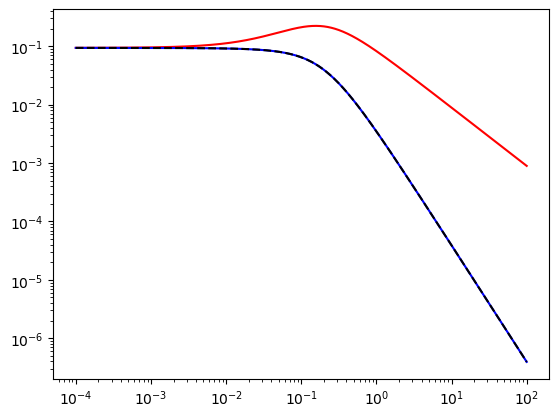

In [5]:
plt.plot(arr_deph, (2*arr_pop_deph/(1-2*arr_pop_deph)), color='red' )
plt.plot(arr_deph, (2*arr_pop_gam/(1-2*arr_pop_gam)), color='blue' )
plt.plot(arr_deph, 8*(Om**2/( (arr_deph+gam)**2. + 4*Delta**2 )) , color='black', linestyle='--' )
plt.yscale('log')
plt.xscale('log')


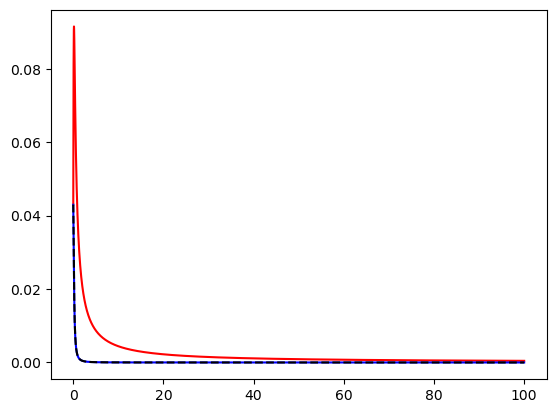

In [6]:
Sat = 8*(Om**2/( (arr_deph+gam)**2. + 4*Delta**2 ))
plt.plot(arr_deph, arr_pop_deph, color='red' )
plt.plot(arr_deph, arr_pop_gam, color='blue' )
plt.plot(arr_deph, .5*Sat/(1+Sat) , color='black', linestyle='--' )


Text(0.5, 0, 'FWHM')

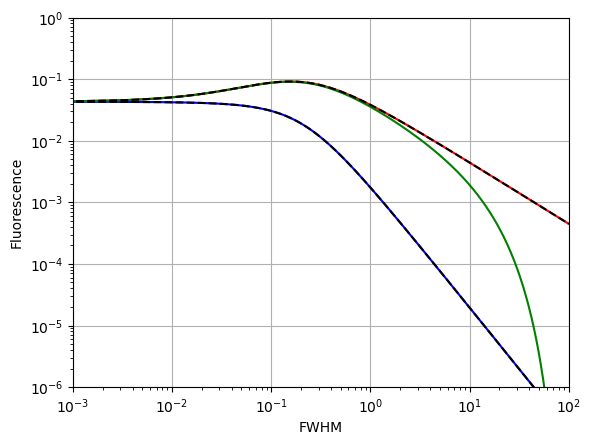

In [7]:
Sat = 8*(Om**2/( (arr_deph+gam)**2. + 4*Delta**2 ))

S_d = 8*Om**2*(arr_deph+gam)/(gam*(4*Delta**2+(arr_deph+gam)**2))
fluo_d = .5*S_d/(1+S_d)
#plt.plot(arr_pop_deph, arr_deph,  color='red' )
#plt.plot(arr_pop_gam, arr_deph,  color='blue' )
#plt.plot(arr_pop_deph_OM, arr_deph,  color='green' )
#plt.plot(.5*Sat/(1+Sat) , arr_deph,  color='black', linestyle='--' )
plt.plot( arr_deph, arr_pop_deph,  color='red' )
plt.plot( arr_deph, arr_pop_gam,  color='blue' )
plt.plot( arr_deph, arr_pop_deph_OM,  color='green' )
plt.plot( arr_deph, .5*Sat/(1+Sat) ,  color='black', linestyle='--' )
plt.plot( arr_deph, fluo_d ,  color='black', linestyle='--' )


plt.yscale('log')
plt.xscale('log')

plt.xlim(1e-3,1e2)
plt.ylim(1e-6,1e0)

plt.grid()

plt.ylabel("Fluorescence")
plt.xlabel("FWHM")

In [8]:
Nd = 600
arr_Om = np.linspace(0.01,1,Nd)
arr_pop_Om = np.zeros(Nd)
Delta = 0
deph = .044

for nD, Om in enumerate(arr_Om):
    H = Delta * s_.dag()*s_ + Om * ( s_ + s_.dag() )
    c_jumps = [gam**.5*s_, deph**.5*s_.dag()*s_]
    rhoss = steadystate(H, c_jumps)
    arr_pop_Om[nD] = expect(s_.dag()*s_, rhoss)

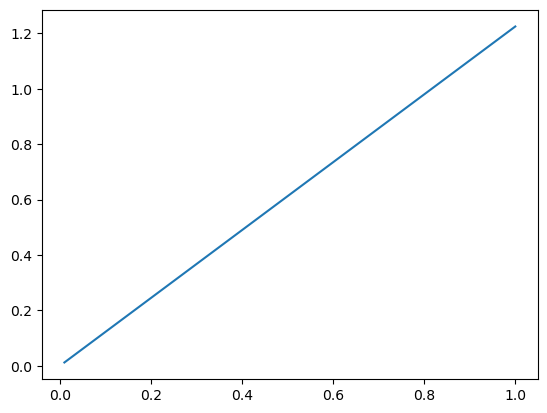

In [9]:
plt.plot( arr_Om, (2*arr_pop_Om/(1.-2*arr_pop_Om) * gam*(gam+deph/2.)**1/4)**.5 )

In [10]:
#OFF RESONANT SATURATION

Nd = 1000
arr_deph = np.logspace(-4,2,Nd)

arr_pop_deph = np.zeros(Nd)
arr_pop = np.zeros(Nd)

Delta = .0
Om0 = .0222
Om00 = 10.
gam = .044
gam_v = 20

eta = 0.3
TF = 5
Tdeph = 10

for nD, deph in enumerate(arr_deph):
    T = deph/1. * Tdeph + 3
    DB = np.exp( - (T/TF)**1 )
    Om = Om0 * (deph/1.)**.25
    Gam_p = eta**2 * Om**2 * DB**2 / gam_v
    
    Om = Om00 * (deph/1.)**.5
    Gam_p0 = eta**2 * Om**2 / gam_v
    #Gam_p1 = eta**2 * Om**4 / gam_v*.05
    Gam_p1 = (eta*Om)**3 * 1e-1
    
    H = Delta * s_.dag()*s_ 
    c_jumps = [gam**.5*s_, Gam_p**.5*s_.dag(), deph**.5*s_.dag()*s_]
    rhoss = steadystate(H, c_jumps)
    arr_pop_deph[nD] = expect(s_.dag()*s_, rhoss)
    
    H = Delta * s_.dag()*s_ 
    c_jumps = [gam**.5*s_, Gam_p0**.5*s_.dag(), Gam_p1**.5*( s_ ) ]
    rhoss = steadystate(H, c_jumps)
    arr_pop[nD] = expect(s_.dag()*s_, rhoss)

Text(0, 0.5, 'Fluorescence')

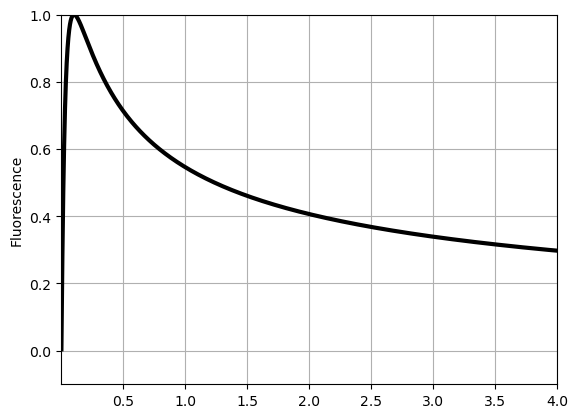

In [11]:
#plt.plot( arr_deph, arr_pop_deph/np.amax(arr_pop_deph) ,  color='green', linestyle='--' )
plt.plot( arr_deph, arr_pop/np.amax(arr_pop) ,  color='black', linestyle='-', linewidth=3 )


#plt.yscale('log')
#plt.xscale('log')

plt.xlim(1e-4,4e0)
plt.ylim(-.1,1e0)

plt.grid()

plt.ylabel("Fluorescence")

In [12]:
Ndph = 100
NDe = 4000
arr_pop = np.zeros(shape=(Ndph,NDe) )

Delta = .0
Om0 = .0222
Om00 = 10.
gam = .1
gam_v = 20

eta = 0.3


vDelta = np.linspace(-50,50,NDe)
#vOm = np.linspace(.01, 10, Ndph)
vOm = np.logspace(-2, .5, Ndph)
for ndph, deph in enumerate(vOm):
    Om = deph
    #Gam_p1 = Om**4 / gam_v*1e2
    Gam_p1 = Om**3 * 1e0
    
    for nD, Delta in enumerate(vDelta):
        H = Delta * s_.dag()*s_ + Om * ( s_ + s_.dag() )
        c_jumps = [gam**.5*s_, Gam_p1**.5*( s_ ) ]
        rhoss = steadystate(H, c_jumps)
        arr_pop[ndph][nD] = expect(s_.dag()*s_, rhoss)

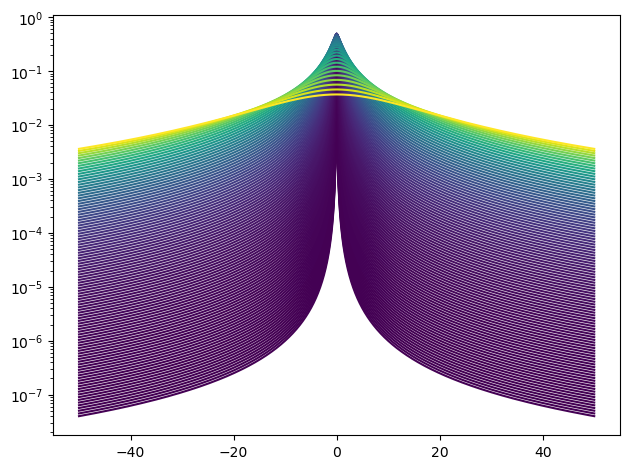

In [13]:
# Choose a colormap
cmap = plt.get_cmap("viridis")

Fluo = np.zeros(Ndph)
# Normalize vOm values → [0, 1]
norm = plt.Normalize(vOm.min(), vOm.max())

for ndph, deph in enumerate(vOm):
    color = cmap(norm(deph))
    plt.plot(vDelta, arr_pop[ndph], color=color)
    Fluo[ndph] = np.amax(arr_pop[ndph])

# Add a colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
#plt.colorbar(sm)
plt.yscale('log')
plt.tight_layout()
plt.show()

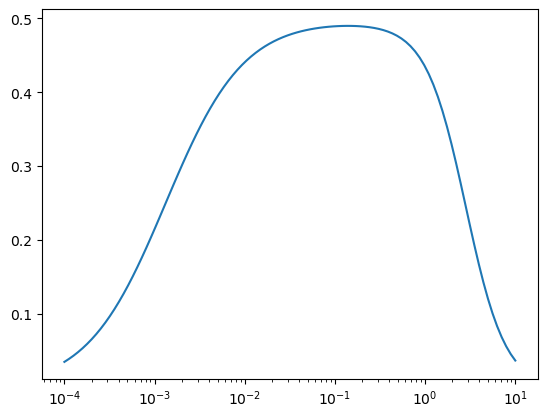

In [14]:
plt.plot(vOm**2, Fluo)
plt.xscale('log')

In [15]:
from scipy.signal import find_peaks, peak_widths

fwhm_all = []

for ndph in range(arr_pop.shape[0]):
    y = arr_pop[ndph]
    peaks, _ = find_peaks(y)

    if len(peaks) == 0:
        fwhm_all.append(np.nan)
        continue

    p = peaks[np.argmax(y[peaks])]
    width = peak_widths(y, [p], rel_height=0.5)[0][0]
    fwhm_all.append(width)

fwhm_all = np.array(fwhm_all)

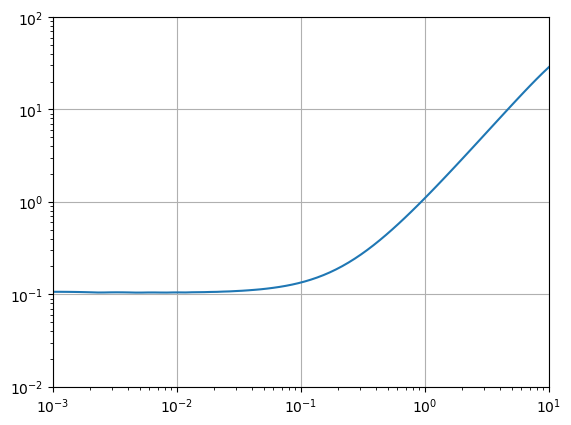

In [16]:
aaa = 2
Sexp = aaa*1*Fluo/(1. - aaa*1*Fluo)
dom = abs(vDelta[1]-vDelta[0])
gam_exp = fwhm_all*dom /(1+Sexp)**.5
plt.plot(vOm**2,gam_exp)
#plt.ylim(0,5.)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-3,1e1)
plt.ylim(1e-2,1e2)
plt.grid()

(0.001, 10.0)

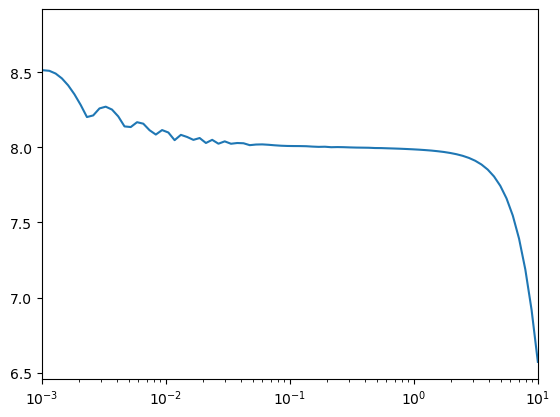

In [17]:
plt.plot(vOm**2,(gam_exp)**2.*Sexp/vOm**2)
plt.xscale('log')
#plt.yscale('log')
plt.xlim(1e-3,1e1)


In [82]:
Nv = 3
s_ = tensor(sigmam(), qeye(Nv))
b = tensor(qeye(2), destroy(Nv))

vk = np.linspace(0,40,100)
vS = np.zeros(len(vk))
gv = 20
g = 1e-1
Om = 1
for nk, k in enumerate(vk):
    c_jumps = [ g**.5 *s_, gv**.5 *b, k**.5 *b*s_  ]
    H = 0 * s_.dag()*s_ + Om*( b*s_ + (b*s_).dag() )
    
    rhoss = steadystate(H, c_jumps)
    pop = expect(s_.dag()*s_, rhoss)
    S = pop/(1.-pop)
    vS[nk] = S


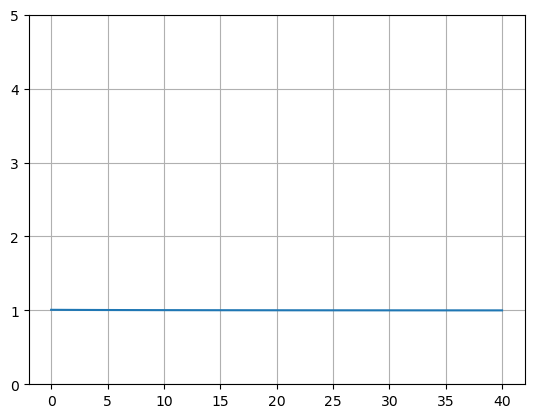

In [85]:
Sa = 4*Om**2/(g*gv)
plt.plot(vk, (Sa/vS)**.5/(1.+vk/gv) )
plt.ylim(0,5)
plt.grid()